# Classifying VS from ALeRCE ZTF explorer

In [1]:
import matplotlib.pyplot as plt
from alerce.core import Alerce
import numpy as np
import pandas as pd
alerce = Alerce()

### Getting light curves from the ALeRCE client

In [323]:
%%time
classifiers = alerce.query_classifiers()
for clasifier in classifiers:
    print(clasifier['classifier_name'])
    print(clasifier['classes'])

lc_classifier
['SNIa', 'SNIbc', 'SNII', 'SLSN', 'QSO', 'AGN', 'Blazar', 'CV/Nova', 'YSO', 'LPV', 'E', 'DSCT', 'RRL', 'CEP', 'Periodic-Other']
lc_classifier_top
['Transient', 'Stochastic', 'Periodic']
lc_classifier_transient
['SNIa', 'SNIbc', 'SNII', 'SLSN']
lc_classifier_stochastic
['QSO', 'AGN', 'Blazar', 'CV/Nova', 'YSO']
lc_classifier_periodic
['LPV', 'E', 'DSCT', 'RRL', 'CEP', 'Periodic-Other']
stamp_classifier
['SN', 'AGN', 'VS', 'asteroid', 'bogus']
stamp_classifier
['SN', 'AGN', 'VS', 'asteroid', 'bogus']
CPU times: user 20.8 ms, sys: 113 µs, total: 20.9 ms
Wall time: 846 ms


In [329]:
%%time
classes = ['LPV', 'E', 'DSCT', 'RRL', 'CEP', 'Periodic-Other']
objects_df = []
for cls in classes:
    params = {
       "classifier": "lc_classifier_periodic",
       "class_name": cls,
       "probability": 0.6,
       "page_size":20,
       "ndet":[300,]
    }
    objects = alerce.query_objects(**params)
    objects_df.append(objects)
objects_df = pd.concat(objects_df)

CPU times: user 63.5 ms, sys: 0 ns, total: 63.5 ms
Wall time: 1.26 s


In [330]:
objects_df_2 = objects_df.copy()
objects_df_2['class'] = objects_df['class'].replace({'SNIa':'SNI', 'SNIbc':'SNI'})

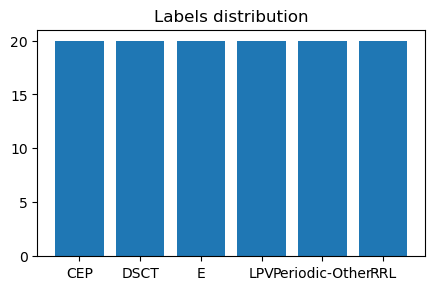

In [331]:
uniques, counts = np.unique(objects_df_2['class'], return_counts=True)

plt.figure(figsize=(5,3), dpi=100)
x_range = range(len(uniques))
plt.bar(x_range, counts)
plt.xticks(x_range, uniques)
plt.title('Labels distribution')
plt.show()

In [332]:
%%time
X, y = [], []
for index, row in objects_df_2.iterrows():
    det = alerce.query_detections(row['oid'],
                                  format="pandas",
                                  sort="mjd")
    lc = det[(det.fid == 1)][['mjd', 'magpsf', 'sigmapsf']]
    lc.dropna(inplace=True)
    lc.sort_values('mjd', inplace=True)
    X.append(lc.values)
    y.append(list(uniques).index(row['class']))

CPU times: user 2.03 s, sys: 29.6 ms, total: 2.06 s
Wall time: 1min 27s


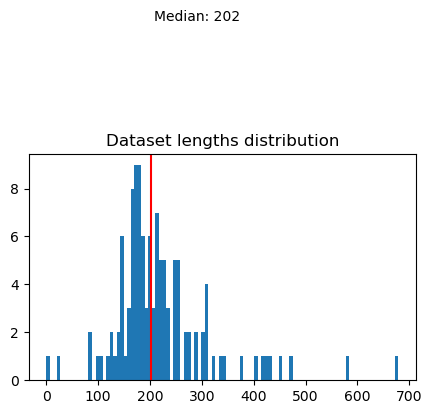

In [333]:
lengths = [x.shape[0] for x in X]
plt.figure(figsize=(5,3), dpi=100)
plt.hist(lengths, bins=100)
len_median = np.median(lengths)
plt.axvline(x=len_median, color='r')
plt.text(len_median + 5, 15, 'Median: {:.0f}'.format(len_median))
plt.title('Dataset lengths distribution')
plt.show()

### Finetuning ASTROMER

In [334]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from ASTROMER.preprocessing import load_numpy

In [335]:
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.33, 
                                                  random_state=42)

In [336]:
train_batches = load_numpy(X_train,
                           labels=y_train,
                           batch_size=16,
                           shuffle=False,
                           sampling=True,
                           max_obs=200,
                           msk_frac=0.5,
                           rnd_frac=0.1,
                           same_frac=0.1,
                           repeat=1)

validation_batches = load_numpy(X_val,
                           labels=y_val,
                           batch_size=16,
                           shuffle=False,
                           sampling=True,
                           max_obs=200,
                           msk_frac=0.5,
                           rnd_frac=0.1,
                           same_frac=0.1,
                           repeat=1)

/home/cridonoso/miniconda3/envs/astromer/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2022-08-05 15:49:34.815525: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


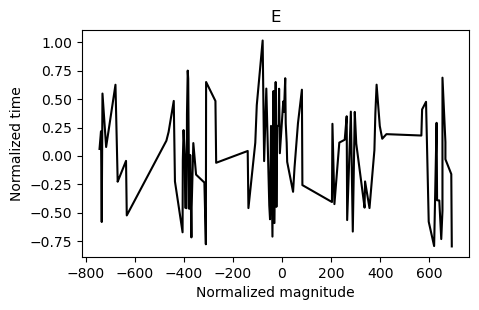

In [337]:
plt.figure(figsize=(5,3), dpi=100)
for batch in train_batches.take(1):
    sample_mags = tf.boolean_mask(batch['input'][0], 1.-batch['mask_in'][0])
    sample_time = tf.boolean_mask(batch['times'][0], 1.-batch['mask_in'][0])
    plt.plot(sample_time, sample_mags, color='k')
    plt.title(uniques[batch['label'][0]])
    plt.xlabel('Normalized magnitude')
    plt.ylabel('Normalized time')
    break

In [338]:
from ASTROMER.models import SingleBandEncoder
tf.config.run_functions_eagerly(True)

astromer = SingleBandEncoder()
astromer = astromer.from_pretraining('macho')

[INFO] Weights already downloaded


In [44]:
%%time
astromer.fit(train_batches,
             validation_batches,
             epochs=100,
             patience=20,
             lr=1e-3,
             project_path='./ztf_sne',
             verbose=0)

EPOCH 99 - ES COUNT: 7.0/20 train mse: 0.1060 - val mse: 0.2348: 100%|█| 100/100 [09:04<00:00,  5.44s/i

CPU times: user 20min 15s, sys: 1min 52s, total: 22min 7s
Wall time: 9min 4s


### Using embeddings to classify 

In [339]:
from sklearn.ensemble import RandomForestClassifier

In [340]:
%%time
embeddings = astromer.encode(X, batch_size=16)

[INFO] Loading numpy arrays


/home/cridonoso/miniconda3/envs/astromer/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


CPU times: user 5.65 s, sys: 534 ms, total: 6.18 s
Wall time: 2.99 s


In [342]:
mean_embs = np.array([np.mean(x, 0) for x in embeddings])
mean_embs.shape

/home/cridonoso/miniconda3/envs/astromer/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cridonoso/miniconda3/envs/astromer/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


(120, 256)

In [367]:
X_train, X_test, y_train, y_test = train_test_split(mean_embs, y, 
                                                    test_size=0.5, 
                                                    random_state=42)
X_train.shape

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [369]:
y_train = np.array(y_train)[~np.isnan(np.mean(X_train, 1))]
X_train = X_train[~np.isnan(np.mean(X_train, 1))]

y_test = np.array(y_test)[~np.isnan(np.mean(X_test, 1))]
X_test = X_test[~np.isnan(np.mean(X_test, 1))]

In [370]:
np.unique(y_train), np.unique(y_test)

(array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]))

In [371]:
clf = RandomForestClassifier(max_depth=2, random_state=0, class_weight='balanced')
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=2, random_state=0)

In [372]:
y_pred = clf.predict(X_test)

In [373]:
from ASTROMER.core.plots import plot_cm
from sklearn.metrics import confusion_matrix

In [374]:
cm = confusion_matrix(y_test, y_pred, normalize='true')

<AxesSubplot:title={'center':'CM'}>

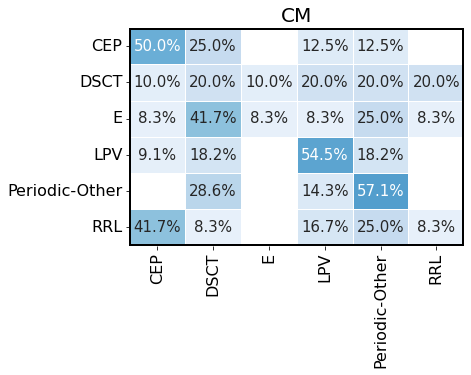

In [375]:
fig, ax = plt.subplots(1,1)
plot_cm(cm, ax, class_names=uniques)

### Using ASTROMER in a TensorFlow model 

In [376]:
from tensorflow.keras.layers import Dense, LayerNormalization, LSTM
from tensorflow.keras import Input, Model

from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [377]:
astromer_encoder = astromer.model.get_layer('encoder')

In [422]:
def build_model(encoder, n_classes, maxlen, train_astromer=False, lr=1e-3):
    serie  = Input(shape=(maxlen, 1), batch_size=None, name='input')
    times  = Input(shape=(maxlen, 1), batch_size=None, name='times')
    mask   = Input(shape=(maxlen, 1), batch_size=None, name='mask')

    placeholder = {'input':serie,
                   'mask_in':mask,
                   'times':times}

    encoder.trainable = train_astromer
    
    mask = 1.-placeholder['mask_in']
    x = encoder(placeholder, training=False)
    x = x * mask
    x = tf.reduce_sum(x, 1)/tf.reduce_sum(mask, 1)

    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = LayerNormalization()(x)
    x = Dense(n_classes)(x)
    
    classifier = Model(inputs=placeholder, outputs=x, name="FCATT")
    
    classifier.compile(loss=CategoricalCrossentropy(), 
                       metrics=['acc'],
                       optimizer=Adam(lr))
    return classifier

In [423]:
classifier = build_model(astromer_encoder, 
                         len(np.unique(y)), 
                         maxlen=astromer.maxlen,
                         train_astromer=False)

In [424]:
X_train, X_val, Y_train, Y_val = train_test_split(X, y, 
                                                  test_size=0.4, 
                                                  random_state=42)

In [425]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def create_windows(lightcurves, labels, winsize=100):
    with tf.device('/CPU:0'):
        windows = []
        win_labels = []
        for index, lc in enumerate(lightcurves):
            lc = lc - np.mean(lc, 0)
            pivots = np.arange(0, lc.shape[0], winsize)
            for pivot in pivots:
                window = lc[pivot:pivot+winsize, :]
                if window.shape[0] < winsize:
                    window = pad_sequences(window.T, 
                                           maxlen=winsize, 
                                           padding='post', 
                                           dtype='float32')
                    window = window.T

                win_labels.append(labels[index])
                windows.append(window)
                
        windows = np.array(windows)
        win_labels = np.array(win_labels)

        return {'input':windows[...,1],
                'times':windows[...,0],
                'mask_in':np.zeros_like(windows[...,1])}, pd.get_dummies(win_labels).values

In [426]:
x_train, y_train = create_windows(X_train, Y_train, winsize=200)
x_test, y_test = create_windows(X_val, Y_val, winsize=200)

In [427]:
history = classifier.fit(x_train, y_train, 
                         epochs=100, 
                         batch_size=16, 
                         validation_split=.2,
                         shuffle=True,
                         callbacks=[EarlyStopping(patience=10)])

Epoch 1/100
6/6 [==============================] - 3s 447ms/step - loss: 6.1324 - acc: 0.1648 - val_loss: 6.3644 - val_acc: 0.2174
Epoch 2/100
6/6 [==============================] - 3s 433ms/step - loss: 10.4626 - acc: 0.1648 - val_loss: 10.5303 - val_acc: 0.2174
Epoch 3/100
6/6 [==============================] - 3s 465ms/step - loss: 10.8085 - acc: 0.1648 - val_loss: 10.5118 - val_acc: 0.2174
Epoch 4/100
6/6 [==============================] - 3s 440ms/step - loss: 10.8044 - acc: 0.1648 - val_loss: 10.5118 - val_acc: 0.2174
Epoch 5/100
6/6 [==============================] - 3s 444ms/step - loss: 10.8044 - acc: 0.1648 - val_loss: 10.5118 - val_acc: 0.2174
Epoch 6/100
6/6 [==============================] - 3s 462ms/step - loss: 10.8044 - acc: 0.1648 - val_loss: 10.5118 - val_acc: 0.2174
Epoch 7/100


KeyboardInterrupt: 

In [397]:
y_pred = classifier.predict(x_test)
y_pred = np.argmax(y_pred, 1)

In [408]:
cm_tf = confusion_matrix(np.argmax(y_test, 1), y_pred, normalize='true')

<AxesSubplot:title={'center':'TF'}>

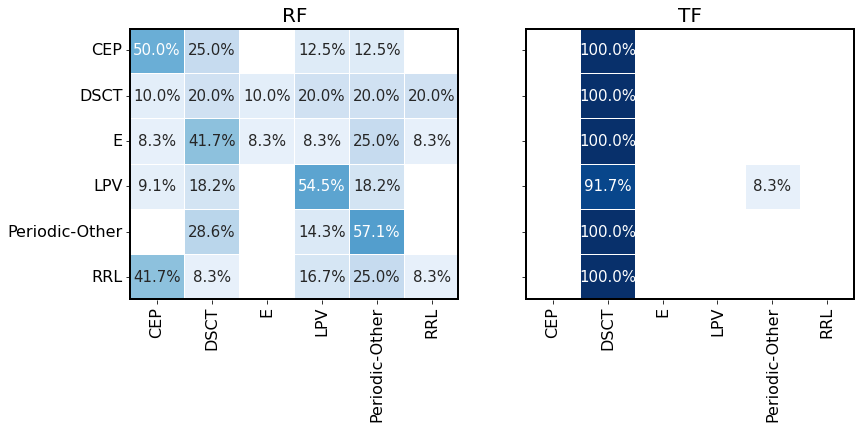

In [409]:
fig, axes = plt.subplots(1,2, figsize=(13,5),sharey=True)
plot_cm(cm, axes[0], class_names=uniques, title='RF')
plot_cm(cm_tf, axes[1], class_names=uniques, title='TF')
